
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1r_ElyehZwlWC7je1ZCsrauqKAObqnjNN?usp=sharing)

# Violence Detection In Movie Scenes

## Prepare the runtime

In [ ]:
!pip install colab-convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colab-convert: filename=colab_convert-2.0.5-py3-none-any.whl size=19224 sha256=433c19571c3c447ddaa7553ec51fa7089200d7f02a94bc6b41e29406ebfdc659
  Stored in directory: /root/.cache/pip/wheels/04/f2/9d/ee946c8db91ba06736f0fc6d0391421f891d5e19785ce707f6
Successfully built colab-convert


In [ ]:
!pip show colab-convert
print()
!pip show numpy
print()
!pip show tensorflow
print()
!pip show opencv-python
print()
!pip show pyyaml
print()
!pip show h5py

Name: colab-convert
Version: 2.0.5
Summary: Convert .py files runnable in VSCode/Python or Atom/Hydrogen to jupyter/colab .ipynb notebooks and vice versa
Home-page: https://github.com/MSFTserver/colab-convert
Author: HostsServer
Author-email: msftserver@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: json5
Required-by: 

Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, xarray-einstats, wordcloud, torchvision, torchtext, tifffile, thinc, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qudida, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc, pyerfa, pyemd

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes'
%ls -a

Mounted at /content/drive/
/content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes
cc-outputs.log  convert.txt  .gitignore          info.txt     requirements.txt
Combined/       Crowd2@      git_interactive.py  Movies/      sync.sh
config_user.sh  .git/        Hockey@             new_repo.sh


### Imports

In [ ]:
import tensorflow as tf
from tensorflow      import keras
from keras           import layers as tfl
from keras.callbacks import EarlyStopping
from keras.backend   import clear_session


import os
import numpy as np
import cv2 
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

'/device:GPU:0'

## Sync with Github

In [ ]:
# !git config user.email "moharamfatema@gmail.com"
# !git config user.name "moharamfatema"

# !python3 git_interactive.py

repo owner: moharamfatema
repo name: violence-detection-paper-replicatio
Enter your username:



In [ ]:
# !git add Movies/movies-data.py
# !git commit -m "+svm and rf movies"
# !git push moharamfatema-origin main

cc-outputs.log  Crowd2@           git_interactive.py  new_repo.sh
Combined/       forest_model.pkl  Hockey@             requirements.txt
config_user.sh  .git/             info.txt            svm_model.pkl
convert.txt     .gitignore        Movies/             sync.sh
[main 767af37] +svm and rf movies
 1 file changed, 439 insertions(+), 118 deletions(-)


## Data Preprocessing

### Define Constants

In [ ]:
# define input paths

ROOT_PATH = '/content/drive/MyDrive/automatic-detection-of-violence-in-video-scenes'
MOVIES_PATH = ROOT_PATH + '/Movies/Movies Fight Dataset'

VIOLENCE_PATH = MOVIES_PATH + '/Violence'
NORMAL_PATH = MOVIES_PATH + '/Normal'

print(os.listdir(NORMAL_PATH)[-1])
print(os.listdir(VIOLENCE_PATH)[-1])

# define output paths

OUT_PATH = ROOT_PATH + '/Movies/out'


60.mpg
newfi67.avi


### Process raw data

In [ ]:
# @title define extraction function
# @markdown define the default parameters:

DIMENSIONS = (50, 50) # @param
PACKET_LENGTH = 15 # @param

def extract_frames(
    directory: str, 
    permutation: np.ndarray,
    dimensions: tuple = DIMENSIONS, 
    packet_length: int = PACKET_LENGTH, 
    save_path: str = None
    ) -> np.ndarray:
  """ Extract packets from video directory

  Parameters
  -----------
  directory : str
    A directory on the disk that contains the videos 

  dimensions: Tuple of shape 2 , optional
    The desired frame dimensions to be stored
    default = (50,50)

  permutation : tuple
    the boundaries of the data taken from the directory

  packet_length: int , optional
    Packet length , Default = 15

  save_dir : str , optional
    The path to which the axtracted data should be saved

  Returns
  -------
  ndarray 
    The extracted packets from each video stacked together 
  """
  data = []
    
  for video_name in np.array(os.listdir(directory))[permutation]:
    video = cv2.VideoCapture(directory + '/' + video_name )
    packet = []
    i = 0

    while video.isOpened():
      ret, frame = video.read()

      if not ret: # no more frames
        break
      
      del ret

      if i % 2 == 0: # capture one in every 2 frames
        i += 1
        continue

      # capturing the frame

      frame = cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      packet.append(frame)
      del frame

      if len(packet) == packet_length: 
        '''
        consecutive packets share 14 of the 15 frames to generate more data
        '''
        # packet itself is not normalized
        stacked = np.array(packet) / 255. # convert to numpy and normalize packet
        data.append(stacked.copy()) # this .copy() is not in the original code 
        packet.pop(0) 

      i += 1

    video.release()
    cv2.destroyAllWindows()
  
  del packet
  # TODO: read the docs for the next 2 lines
  data = np.stack(data, axis= 0)
  data = np.moveaxis(data, 1 ,-1)

  # save to disk
  if(save_path is not None):
    np.save(f'{save_path}',data)

  return data

In [ ]:
def process_np(normal, violence):
  subset = min(len(normal),len(violence))

  y = np.concatenate([np.zeros(subset), np.ones(subset)])
  x = np.concatenate([normal[:subset,:,:,:], violence[:subset,:,:,:]], axis = 0)

  print((x.shape, y.shape))

  #shuffle
  per = np.random.permutation(len(x))

  x = x[per,:,:,:]
  y = y[per]
  y = y.astype(int)

  y = np.expand_dims(y, -1)

  return x, y

In [ ]:
def save_datasets(
    save_path: str
  ) -> np.ndarray:
  
  normal_random = np.random.permutation(100)
  violence_random = np.random.permutation(100)

  # train
  normal_data = extract_frames(f'{MOVIES_PATH}/Normal', normal_random[:70])
  violence_data = extract_frames(f'{MOVIES_PATH}/Violence', violence_random[:70])

  x, y = process_np(normal_data, violence_data)
  del normal_data
  del violence_data

  np.save(f'{save_path}/x_train',x)
  np.save(f'{save_path}/y_train',y)

  del x
  del y

  # validation
  normal_data = extract_frames(f'{MOVIES_PATH}/Normal', normal_random[70:85])
  violence_data = extract_frames(f'{MOVIES_PATH}/Violence', violence_random[70:85])

  x, y = process_np(normal_data, violence_data)
  del normal_data
  del violence_data

  np.save(f'{save_path}/x_val',x)
  np.save(f'{save_path}/y_val',y)

  del x
  del y

  # test
  normal_data = extract_frames(f'{MOVIES_PATH}/Normal', normal_random[85:])
  violence_data = extract_frames(f'{MOVIES_PATH}/Violence', violence_random[85:])

  x, y = process_np(normal_data, violence_data)
  del normal_data
  del violence_data

  np.save(f'{save_path}/x_test',x)
  np.save(f'{save_path}/y_test',y)

  del x
  del y

In [ ]:
# save_datasets(OUT_PATH)

### Load pre-saved and pre-processed data

In [ ]:
# Load Data

def load_x_y(
    load_which: str = 'train', 
  ):
  violence_data = None
  normal_data = None

  if load_which == 'train':
    x = np.load(f'{OUT_PATH}/x_train.npy')
    y  = np.load(f'{OUT_PATH}/y_train.npy')

  elif load_which == 'validation':
    x = np.load(f'{OUT_PATH}/x_val.npy')
    y  = np.load(f'{OUT_PATH}/y_val.npy')

  elif load_which == 'test':
    x = np.load(f'{OUT_PATH}/x_test.npy')
    y  = np.load(f'{OUT_PATH}/y_test.npy')

  print(f'y shape = {y.shape}')
  print(f'x shape = {x.shape}')

  return x, y

In [ ]:
x_train, y_train = load_x_y('train')

x_val, y_val = load_x_y('validation')

x_test, y_test = load_x_y('test')



y shape = (1414, 1)
x shape = (1414, 50, 50, 15)
y shape = (284, 1)
x shape = (284, 50, 50, 15)
y shape = (288, 1)
x shape = (288, 50, 50, 15)


## Model Description

In [ ]:
# del model

In [ ]:
def create_model():
  model = keras.Sequential([
    tfl.Conv2D(
        128, 
        (3,3), 
        activation = 'relu',
        input_shape = (50, 50, 15),
        padding = 'same'
      ),
    tfl.Dropout(0.2),
    tfl.MaxPooling2D(2,2),
    tfl.BatchNormalization(),

    tfl.Conv2D(256, (3,3), activation = 'relu'),
    tfl.Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
    tfl.MaxPooling2D(2,2),
    tfl.BatchNormalization(),

    tfl.Conv2D(512, (3,3), activation = 'relu'),
    tfl.Conv2D(512, (3,3), activation = 'relu', padding = 'same'),
    tfl.MaxPooling2D(2,2),
    tfl.BatchNormalization(),

    tfl.Conv2D(1024, (3,3), activation = 'relu', padding = 'same'),
    tfl.Conv2D(1024, (3,3), activation = 'relu', padding = 'same'),
    tfl.MaxPooling2D(2,2),
    tfl.BatchNormalization(),

    # Flatten the results to feed into the densely connected laye.
    tfl.Flatten(),
    # 512 neuron hidden laye.
    tfl.Dense(2048, activation = 'relu'),
    tfl.Dropout(0.2),

    tfl.Dense(512, activation = 'relu'),
    tfl.Dropout(0.2),

    tfl.Dense(128, activation = 'relu'),
    tfl.Dropout(0.2),

    # Only 1 output neuron for binary classification tas.
    tfl.Dense(1, activation = 'sigmoid')

  ])
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = keras.optimizers.Adam(learning_rate = 0.00003),
      metrics = ['acc', keras.metrics.Recall(), keras.metrics.Precision()]
    )
  
  return model

# model = create_model()
#model.summary()

In [ ]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

# Clear any logs from previous runs
# !rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
early_stopping_cb = EarlyStopping(patience = 13, restore_best_weights= True)

log_dir = OUT_PATH + "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
'''
history = model.fit(x = x_train,
          y = y_train,
          batch_size = 20,
          epochs=100,
          validation_data = (x_val, y_val),          
          callbacks=early_stopping_cb,
  )
'''

Epoch 1/100
71/71 [==============================] - 22s 92ms/step - loss: 0.1150 - acc: 0.9569 - recall: 0.9802 - precision: 0.9365 - val_loss: 0.6506 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/100
71/71 [==============================] - 4s 56ms/step - loss: 0.0049 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.3048 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 3/100
71/71 [==============================] - 4s 56ms/step - loss: 0.0021 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.2492 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 4/100
71/71 [==============================] - 4s 56ms/step - loss: 8.5153e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.2275 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 5/100
71/71 [==============================] - 4s 56ms/step - loss: 7.6213e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - v

In [ ]:
model = create_model()
model.load_weights(f'{OUT_PATH}/checkpoints/model-30-8-22-23-23')

In [ ]:
eval_history = model.evaluate(x_test, y_test)

9/9 [==============================] - 12s 19ms/step - loss: 3.3979e-04 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000


## Metrics

In [ ]:
y_pred = model.predict(x_test)

### Drawing ROC curve


Logistic: ROC AUC=1.000
Best Threshold=0.970337, G-Mean=1.000


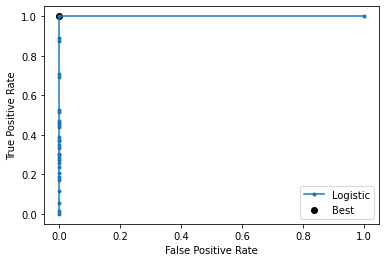

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# keep probabilities for the positive outcome only
y_pred = y_pred[:]
# calculate scores
ns_auc = roc_auc_score(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('EER: %f' % EER)

EER: 0.000000


### Confusion Matrix

In [ ]:
y_pred = [1 * (x[0]>=thresholds[ix]) for x in y_pred]
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1], 
                     columns = [0,1])

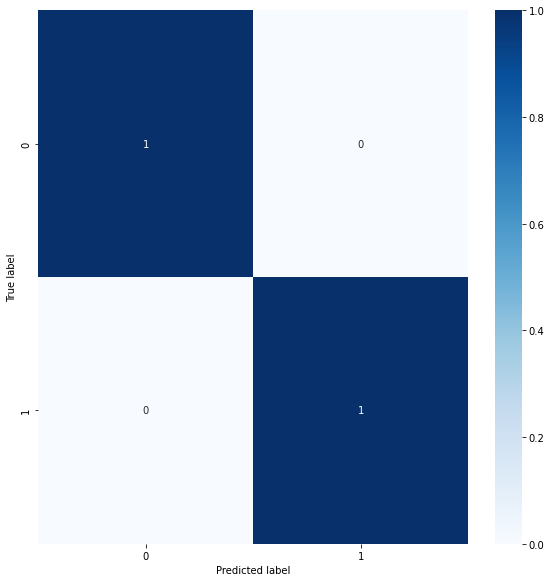

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')  
plt.xlabel('Predicted label')
plt.show()

In [ ]:
acc = (con_mat[0][0] + con_mat[1][1]) / (con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1]) 
print('Accuracy when predicting based on best threshold: %f' % acc)

Accuracy when predicting based on best threshold: 1.000000


## Extract features from dense layer and use it to train an SVM classifier and a RF classifier

In [ ]:
model_feat = keras.models.Model(inputs=model.input,outputs=model.layers[-7].output)

In [ ]:
feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(1414, 2048)
(284, 2048)
(288, 2048)


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,y_train)

print('fitting done !!!')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fitting done !!!


In [ ]:
svm.score(feat_test,y_test)

1.0

In [ ]:
with open('svm_model.pkl','wb') as f:
    pickle.dump(svm,f)


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(feat_train, y_train)

clf.score(feat_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


1.0

In [ ]:
with open('forest_model.pkl','wb') as f:
    pickle.dump(clf,f)